# Detecting Distracted Driving

In [ ]:
!pip install anvil-uplink
import anvil.server
import anvil.media
anvil.server.connect("XZYP2RBRVGD3JTDYVBEMG5ZP-6KX5RTGZWY6ZXPGG")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import pickle 
import PIL
import torch
import math
from torchvision import transforms
from tensorflow import keras
from timeit import default_timer as timer
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras import initializers
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.callbacks import LearningRateScheduler

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


## Load & Process Data

Downloaded from [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview)

In [ ]:
## Mount the google drive
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/INDENG 135/state-farm-distracted-driver-detection/

/content/drive/MyDrive/INDENG 135/state-farm-distracted-driver-detection


In [ ]:
driver_imgs_list = pd.read_csv('driver_imgs_list.csv')
driver_imgs_list

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


### Create X

In [ ]:
try:
    # Load
    X = pickle.load(open('X.pckl', 'rb'))
except (OSError, IOError, EOFError) as e:
    # Write
    training_imgs1 = os.listdir('imgs/training')

    X = np.zeros((len(training_imgs1), 480, 640, 3))
    for i, filename in enumerate(training_imgs1):
        img = np.asarray(Image.open('imgs/training/' + filename))
        X[i] = img
    X = X / 255
    pickle.dump(X, open('X.pckl', 'wb'))

In [ ]:
X.shape

(360, 480, 640, 3)

### Create y

In [ ]:
training_imgs = os.listdir('imgs/training')
img_class = []
for i, filename in enumerate(training_imgs):
    img_class.append(driver_imgs_list[driver_imgs_list['img'] == filename]['classname'].values[0])

y = np.zeros(len(training_imgs))
for i, c in enumerate(img_class):
    if c != 'c0':
        y[i] = 1

In [ ]:
# y to Categorical
y = tf.keras.utils.to_categorical(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Check distributions of classes in training and validation data
sum(y_train)/288, sum(y_val)/72

(array([0.48958334, 0.5104167 ], dtype=float32),
 array([0.5416667 , 0.45833334], dtype=float32))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(288, 480, 640, 3)
(288, 2)


## Models

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.008
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
   
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

### Basic CNN

In [ ]:
# Run this cell, no need to modify
cnn = Sequential()

cnn.add(Conv2D(filters=6, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(480, 640, 3)))
cnn.add(AveragePooling2D())

cnn.add(Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'))
cnn.add(AveragePooling2D())

cnn.add(Flatten())
cnn.add(Dense(units=10, activation='relu'))
cnn.add(Dense(units=2, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 640, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 240, 320, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 120, 160, 16)     0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 307200)            0         
                                                                 
 dense (Dense)               (None, 10)                3

In [ ]:
cnn.compile(loss = 'categorical_crossentropy',
             optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9, nesterov=True),
             metrics = ['accuracy'])

cnn.fit(x=X_train, 
          y=y_train, 
          epochs=30, 
          validation_data=(X_val, y_val),
          batch_size=32,
          callbacks=callbacks_list
        )

_, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy = {0:f}'.format(train_acc))

Epoch 1/30
9/9 [==============================] - 35s 467ms/step - loss: 1.0290 - accuracy: 0.5347 - val_loss: 0.6921 - val_accuracy: 0.4583 - lr: 0.0100
Epoch 2/30
9/9 [==============================] - 3s 348ms/step - loss: 0.6896 - accuracy: 0.5625 - val_loss: 0.6804 - val_accuracy: 0.7083 - lr: 0.0100
Epoch 3/30
9/9 [==============================] - 3s 351ms/step - loss: 0.6634 - accuracy: 0.6736 - val_loss: 0.6614 - val_accuracy: 0.7639 - lr: 0.0100
Epoch 4/30
9/9 [==============================] - 3s 349ms/step - loss: 0.7150 - accuracy: 0.6806 - val_loss: 0.6969 - val_accuracy: 0.4583 - lr: 0.0100
Epoch 5/30
9/9 [==============================] - 3s 342ms/step - loss: 0.6936 - accuracy: 0.5104 - val_loss: 0.6945 - val_accuracy: 0.4583 - lr: 0.0100
Epoch 6/30
9/9 [==============================] - 3s 387ms/step - loss: 0.6934 - accuracy: 0.5104 - val_loss: 0.6950 - val_accuracy: 0.4583 - lr: 0.0100
Epoch 7/30
9/9 [==============================] - 3s 349ms/step - loss: 0.6934 - 

### CNN with VGG16

In [ ]:
vgg16 = Sequential()

vgg16.add(tf.keras.layers.InputLayer(
    input_shape=(480, 640, 3), batch_size=None, dtype=None, input_tensor=None, sparse=None,
    name=None, ragged=None, type_spec=None
))

vgg16.add(tf.keras.layers.Resizing(
    224, 224, interpolation="bilinear", crop_to_aspect_ratio=False
))

vgg16.add(tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
))

vgg16.add(Flatten())
vgg16.add(Dense(units=2, activation='softmax'))

vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 14,764,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vgg16.compile(loss = 'categorical_crossentropy',
             optimizer = keras.optimizers.SGD(learning_rate=0.008, momentum = 0.9, nesterov=True),
             metrics = ['accuracy'])

vgg16.fit(x=X_train, 
          y=y_train, 
          epochs=40, 
          validation_data=(X_val, y_val),
          batch_size=32,
          callbacks=callbacks_list)

_, train_acc = vgg16.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy = {0:f}'.format(train_acc))

Epoch 1/40
9/9 [==============================] - 54s 1s/step - loss: 0.6936 - accuracy: 0.4618 - val_loss: 0.6936 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 2/40
9/9 [==============================] - 8s 940ms/step - loss: 0.6927 - accuracy: 0.5104 - val_loss: 0.6942 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 3/40
9/9 [==============================] - 8s 933ms/step - loss: 0.6924 - accuracy: 0.5104 - val_loss: 0.6946 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 4/40
9/9 [==============================] - 8s 933ms/step - loss: 0.6919 - accuracy: 0.5104 - val_loss: 0.6944 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 5/40
9/9 [==============================] - 8s 931ms/step - loss: 0.6915 - accuracy: 0.5104 - val_loss: 0.6937 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 6/40
9/9 [==============================] - 8s 929ms/step - loss: 0.6914 - accuracy: 0.5104 - val_loss: 0.6940 - val_accuracy: 0.4583 - lr: 0.0080
Epoch 7/40
9/9 [==============================] - 8s 925ms/step - loss: 0.6907 - acc

### CNN with VGG19

In [ ]:
vgg19 = Sequential()

vgg19.add(tf.keras.layers.InputLayer(
    input_shape=(480, 640, 3), batch_size=None, dtype=None, input_tensor=None, sparse=None,
    name=None, ragged=None, type_spec=None
))

vgg19.add(tf.keras.layers.Resizing(
    224, 224, interpolation="bilinear", crop_to_aspect_ratio=False
))

vgg19.add(tf.keras.applications.VGG19(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
))

vgg19.add(Flatten())
vgg19.add(Dense(units=2, activation='softmax'))

vgg19.summary()

NameError: ignored

In [ ]:
vgg19.compile(loss = 'categorical_crossentropy',
             optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9, nesterov=True),
             metrics = ['accuracy'])

vgg19.fit(x=X_train, 
          y=y_train, 
          epochs=20, 
          validation_data=(X_val, y_val),
          batch_size=32)

_, train_acc = vgg19.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy = {0:f}'.format(train_acc))

## Validation with Best Model

In [ ]:
best_model = vgg16
_, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
print('Validation Accuracy = {0:f}'.format(val_acc))

Validation Accuracy = 0.916667


## Manual Testing

In [ ]:
# Images
print(os.listdir('imgs/testing'))

['img_71538.jpg', 'img_84376.jpg', 'img_73015.jpg', 'img_67309.jpg', 'img_44804.jpg', 'img_46103.jpg', 'img_51480.jpg', 'img_57418.jpg', 'img_72386.jpg', 'img_72576.jpg', 'img_66928.jpg', 'img_63816.jpg', 'img_73039.jpg', 'img_72593.jpg', 'img_19203.jpg', 'img_45485.jpg', 'img_61521.jpg', 'img_70290.jpg', 'img_64817.jpg', 'img_57608.jpg']


In [ ]:
#@title Select an image

select_img = 'img_84376.jpg'  #@param ['img_73015.jpg', 'img_67309.jpg', 'img_44804.jpg', 'img_46103.jpg', 'img_51480.jpg', 'img_57418.jpg', 'img_72386.jpg', 'img_72576.jpg', 'img_66928.jpg', 'img_63816.jpg', 'img_73039.jpg', 'img_72593.jpg', 'img_19203.jpg', 'img_45485.jpg', 'img_61521.jpg', 'img_70290.jpg', 'img_64817.jpg', 'img_57608.jpg', 'img_84376.jpg', 'img_71538.jpg']


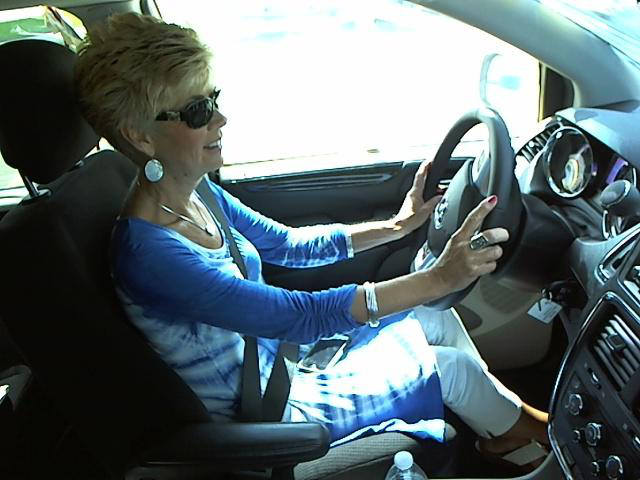

In [ ]:
# Open Image
img = np.array([np.asarray(Image.open('imgs/testing/' + select_img))])
Image.open('imgs/testing/' + select_img)

In [ ]:
# Prediction
pred = best_model.predict(img)
if pred[0][0] == 1:
  print("Safe Driving")
else:
  print("Distracted Driving")

Safe Driving


## ANVIL

In [ ]:
@anvil.server.callable
def predict(file):
  with anvil.media.TempFile(file) as filename:
    img = Image.open(filename)
    arr = np.array([np.asarray(img)])
    pred = best_model.predict(arr)
    if pred[0][0] == 1:
      return "Safe Driving"
    else:
      return "Distracted Driving"

In [ ]:
anvil.server.wait_forever()

KeyboardInterrupt: ignored